# Toy Example 3

#### Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import ticker
from matplotlib.patches import FancyBboxPatch
from pandas import DataFrame, Index, Series
from tabulate import tabulate

from src import metrics
from src.algorithms import lloyd, fairlloyd_gd, faircentroid

In [2]:
plt.rcParams['axes.edgecolor'] = 'grey'
plt.rcParams['axes.linewidth'] = .5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 'small'
plt.rcParams['xtick.major.size'] = plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.pad'] = plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['xtick.color'] = plt.rcParams['ytick.color'] = 'grey'
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['savefig.pad_inches'] = 0
plt.rcParams['savefig.transparent'] = True
plt.rcParams['scatter.marker'] = 'o'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 5
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = True

#### Plotting functions

In [3]:
def plot(X, s, c=None, centroids=None, ax=None, figsize=(29, 50), pad=.03, figname=None):
    if ax is None:
        mm = 1/25.4
        _, ax = plt.subplots(figsize=(figsize[0]*mm, figsize[1]*mm))
    xmin, xmax = X['x'].aggregate([min, max])
    ymin, ymax = X['y'].aggregate([min, max])
    fpad = 2 * pad * max(xmax-xmin, ymax-ymin)
    _ = ax.set_xlim(0, xmax+fpad)
    _ = ax.set_ylim(0, ymax+fpad)
    if c is not None:
        vertices = X.groupby(c, sort=False).aggregate([min, max])
        cpad = pad * vertices.aggregate(lambda row: max(row[('x', 'max')]-row[('x', 'min')], row[('y', 'max')]-row[('y', 'min')]), axis='columns').max()
        for C, (xmin, xmax, ymin, ymax) in vertices.iterrows():
            width = xmax - xmin + 1.5*cpad
            height = ymax - ymin + 1.5*cpad
            ax.add_patch(FancyBboxPatch((xmin-cpad, ymin-cpad), width, height, boxstyle='round, rounding_size=3', color='gainsboro', alpha=.5))
            _ = ax.annotate(fr"${{C_{C}}}$", (xmin+1.5*cpad, ymin-4*cpad), fontsize=7, ha='right')
    _ = ax.scatter(x=X['x'], y=X['y'], s=1, linewidths=.3, edgecolors=s, facecolors='none', alpha=.4)
    if centroids is not None:
        _ = ax.scatter(x=centroids['x'], y=centroids['y'], s=3, c='black')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.set_aspect('equal')
    if figname is not None:
        ax.figure.savefig(f'data/toy/{figname}.pdf')

#### Dataset

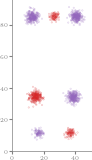

In [4]:
sparsity = .05

r0 = {'mean': [27, 85], 'size': 100}
r0['cov'] = np.sqrt(sparsity * r0['size']) * np.eye(2)

p0a = {'mean': [41, 85], 'size': 300}
p0a['cov'] = np.sqrt(sparsity * p0a['size']) * np.eye(2)

p0b = {'mean': [13, 85], 'size': 300}
p0b['cov'] = np.sqrt(sparsity * p0b['size']) * np.eye(2)

r1 = {'mean': [15, 34], 'size': 300}
r1['cov'] = np.sqrt(sparsity * r1['size']) * np.eye(2)

p1 = {'mean': [17, 11], 'size': 100}
p1['cov'] = np.sqrt(sparsity * p1['size']) * np.eye(2)

r2 = {'mean': [39, 34], 'size': 300}
r2['cov'] = np.sqrt(sparsity * r2['size']) * np.eye(2)

p2 = {'mean': [37, 11], 'size': 100}
p2['cov'] = np.sqrt(sparsity * p2['size']) * np.eye(2)

columns = Index(['x', 'y'], name='attribute')
r0_df = DataFrame(np.random.default_rng(0).multivariate_normal(**r0), columns=columns)
r0_df['color'] = 'tab:red'
p0a_df = DataFrame(np.random.default_rng(1).multivariate_normal(**p0a), columns=columns)
p0a_df['color'] = 'tab:purple'
p0b_df = DataFrame(np.random.default_rng(2).multivariate_normal(**p0b), columns=columns)
p0b_df['color'] = 'tab:purple'

r1_df = DataFrame(np.random.default_rng(3).multivariate_normal(**r1), columns=columns)
r1_df['color'] = 'tab:red'
p1_df = DataFrame(np.random.default_rng(4).multivariate_normal(**p1), columns=columns)
p1_df['color'] = 'tab:purple'

r2_df = DataFrame(np.random.default_rng(5).multivariate_normal(**r2), columns=columns)
r2_df['color'] = 'tab:purple'
p2_df = DataFrame(np.random.default_rng(6).multivariate_normal(**p2), columns=columns)
p2_df['color'] = 'tab:red'

dataset = pd.concat([r0_df, p0a_df, p0b_df, r1_df, p1_df, r2_df, p2_df], ignore_index=True)
dataset.index.name = 'object'
X = dataset.drop('color', axis='columns')
s = dataset.filter(['color'], axis='columns').squeeze()
sensitive_groups = list(s.unique())

plot(X, s)

#### Initial configurations

In [5]:
init_c1 = Series([0]*r0['size'] + [0]*p0a['size'] + [0]*p0b['size'] + [1]*r1['size'] + [1]*p1['size'] + [2]*r2['size'] + [2]*p2['size'], name='cluster')
init_centroids1 = X.groupby(init_c1).mean()
init_centroids1.index.name = 'cluster'

init_c2 = Series([0]*r0['size'] + [0]*p0a['size'] + [0]*p0b['size'] + [1]*r1['size'] + [2]*p1['size'] + [1]*r2['size'] + [2]*p2['size'], name='cluster')
init_centroids2 = X.groupby(init_c2).mean()
init_centroids2.index.name = 'cluster'

#### $k$-means

Configuration:
╭─────────────┬──────────────┬────────────┬────────╮
│   algorithm │   n_clusters │   max_iter │    tol │
├─────────────┼──────────────┼────────────┼────────┤
│       Lloyd │            3 │        200 │ 0.0001 │
╰─────────────┴──────────────┴────────────┴────────╯
Initialising centroids
Running algorithm
╭──────┬───────────────┬───────────────┬────────────────╮
│ iter │     objective │ reassignments │ centroid shift │
├──────┼───────────────┼───────────────┼────────────────┤
│    1 │  205791.02660 │          1500 │              - │
│    2 │  205791.02660 │             0 │    0.00000e+00 │
╰──────┴───────────────┴───────────────┴────────────────╯
Converged at iteration 2: strict convergence


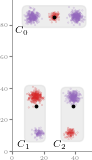

In [6]:
c_lloyd1, centroids_lloyd1 = lloyd.run(n_clusters=3, X=X, init_centroids=init_centroids1)
plot(X=X, s=s, c=c_lloyd1, centroids=centroids_lloyd1, figname='toy-3-kmeans')

Configuration:
╭─────────────┬──────────────┬────────────┬────────╮
│   algorithm │   n_clusters │   max_iter │    tol │
├─────────────┼──────────────┼────────────┼────────┤
│       Lloyd │            3 │        200 │ 0.0001 │
╰─────────────┴──────────────┴────────────┴────────╯
Initialising centroids
Running algorithm
╭──────┬───────────────┬───────────────┬────────────────╮
│ iter │     objective │ reassignments │ centroid shift │
├──────┼───────────────┼───────────────┼────────────────┤
│    1 │  232576.85772 │          1500 │              - │
│    2 │  232576.85772 │             0 │    0.00000e+00 │
╰──────┴───────────────┴───────────────┴────────────────╯
Converged at iteration 2: strict convergence


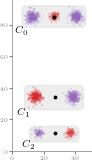

In [7]:
c_lloyd2, centroids_lloyd2 = lloyd.run(n_clusters=3, X=X, init_centroids=init_centroids2)
plot(X=X, s=s, c=c_lloyd2, centroids=centroids_lloyd2)

In [8]:
kwargs = {'X': X, 's': s, 'display': False}
scores_lloyd = pd.concat(
    {'initialisation 1': metrics.evaluate(c=c_lloyd1, centroids=centroids_lloyd1, **kwargs),
     'initialisation 2': metrics.evaluate(c=c_lloyd2, centroids=centroids_lloyd2, **kwargs)
     },
    names=['objectives']
    )
print(tabulate(scores_lloyd.unstack(level='objectives'), headers='keys', tablefmt='rounded_outline'))

Evaluating against all metrics
Evaluating against all metrics
╭───────────────────────────┬────────────────────┬────────────────────╮
│ metric                    │   initialisation 1 │   initialisation 2 │
├───────────────────────────┼────────────────────┼────────────────────┤
│ average cluster disparity │            1.27124 │           0.448709 │
│ k-means objective         │          137.194   │         155.051    │
│ fair centroid objective   │          267.931   │         152.365    │
│ fair k-means objective    │          163.364   │         176.474    │
╰───────────────────────────┴────────────────────┴────────────────────╯


#### fair $k$-means

Configuration:
╭───────────────────────────────┬──────────────┬────────────┬───────┬───────┬───────┬────────────╮
│                     algorithm │   n_clusters │   max_iter │   tol │   eta │   phi │   patience │
├───────────────────────────────┼──────────────┼────────────┼───────┼───────┼───────┼────────────┤
│ Fair-Lloyd (Gradient Descent) │            3 │        200 │ 1e-11 │ 0.001 │  1000 │         10 │
╰───────────────────────────────┴──────────────┴────────────┴───────┴───────┴───────┴────────────╯
Initialising centroids
Running algorithm
╭──────┬───────────┬───────────────┬────────────────╮
│ iter │ objective │ reassignments │ centroid shift │
├──────┼───────────┼───────────────┼────────────────┤
│    1 │ 163.36409 │          1500 │              - │
│    2 │ 143.73350 │             0 │    4.94303e+00 │
╰──────┴───────────┴───────────────┴────────────────╯
Converged at iteration 2: strict convergence


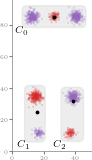

In [9]:
c_fairlloyd1, centroids_fairlloyd1 = fairlloyd_gd.run(n_clusters=3, X=X, s=s, init_centroids=init_centroids1, tol=1e-11)
plot(X=X, s=s, c=c_fairlloyd1, centroids=centroids_fairlloyd1, figname='toy-3-fairkmeans')

Configuration:
╭───────────────────────────────┬──────────────┬────────────┬───────┬───────┬───────┬────────────╮
│                     algorithm │   n_clusters │   max_iter │   tol │   eta │   phi │   patience │
├───────────────────────────────┼──────────────┼────────────┼───────┼───────┼───────┼────────────┤
│ Fair-Lloyd (Gradient Descent) │            3 │        200 │ 1e-11 │ 0.001 │  1000 │         10 │
╰───────────────────────────────┴──────────────┴────────────┴───────┴───────┴───────┴────────────╯
Initialising centroids
Running algorithm
╭──────┬───────────┬───────────────┬────────────────╮
│ iter │ objective │ reassignments │ centroid shift │
├──────┼───────────┼───────────────┼────────────────┤
│    1 │ 176.47404 │          1500 │              - │
│    2 │ 158.03526 │             0 │    2.76639e+00 │
╰──────┴───────────┴───────────────┴────────────────╯
Converged at iteration 2: strict convergence


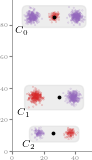

In [10]:
c_fairlloyd2, centroids_fairlloyd2 = fairlloyd_gd.run(n_clusters=3, X=X, s=s, init_centroids=init_centroids2, tol=1e-11)
plot(X=X, s=s, c=c_fairlloyd2, centroids=centroids_fairlloyd2)

In [11]:
kwargs = {'X': X, 's': s, 'display': False}
scores_fairlloyd = pd.concat(
    {'initialisation 1': metrics.evaluate(c=c_fairlloyd1, centroids=centroids_fairlloyd1, **kwargs),
     'initialisation 2': metrics.evaluate(c=c_fairlloyd2, centroids=centroids_fairlloyd2, **kwargs)
     },
    names=['objectives']
    )
print(tabulate(scores_fairlloyd.unstack(level='objectives'), headers='keys', tablefmt='rounded_outline'))

Evaluating against all metrics
Evaluating against all metrics
╭───────────────────────────┬────────────────────┬────────────────────╮
│ metric                    │   initialisation 1 │   initialisation 2 │
├───────────────────────────┼────────────────────┼────────────────────┤
│ average cluster disparity │            1.09681 │           0.727102 │
│ k-means objective         │          143.71    │         157.939    │
│ fair centroid objective   │          265.665   │         181.406    │
│ fair k-means objective    │          143.733   │         158.035    │
╰───────────────────────────┴────────────────────┴────────────────────╯


#### fair centroids

Configuration:
╭───────────────┬──────────────┬────────────┬───────┬───────┬───────┬────────────┬───────────╮
│     algorithm │   n_clusters │   max_iter │   tol │   eta │   phi │   patience │   lambda_ │
├───────────────┼──────────────┼────────────┼───────┼───────┼───────┼────────────┼───────────┤
│ Fair-Centroid │            3 │        200 │ 1e-11 │ 0.001 │  1000 │         10 │       0.9 │
╰───────────────┴──────────────┴────────────┴───────┴───────┴───────┴────────────┴───────────╯
Initialising centroids
Running algorithm
╭──────┬───────────────┬───────────┬───────────┬───────────────┬────────────────╮
│ iter │       utility |  fairness | objective │ reassignments │ centroid shift │
├──────┼───────────────┼───────────┼───────────┼───────────────┼────────────────┤
│    1 │  205791.02660 │ 803.79368 │ 254.85751 │          1500 │              - │
│    2 │  231543.04044 │ 477.36399 │ 158.64540 │             0 │    8.02371e+00 │
╰──────┴───────────────┴───────────┴───────────┴───────────

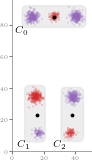

In [12]:
c_faircentroid1, centroids_faircentroid1 = faircentroid.run(n_clusters=3, X=X, s=s, init_centroids=init_centroids1, sensitive_groups=sensitive_groups, lambda_=.9, tol=1e-11)
plot(X=X, s=s, c=c_faircentroid1, centroids=centroids_faircentroid1)

Configuration:
╭───────────────┬──────────────┬────────────┬───────┬───────┬───────┬────────────┬───────────╮
│     algorithm │   n_clusters │   max_iter │   tol │   eta │   phi │   patience │   lambda_ │
├───────────────┼──────────────┼────────────┼───────┼───────┼───────┼────────────┼───────────┤
│ Fair-Centroid │            3 │        200 │ 1e-11 │ 0.001 │  1000 │         10 │       0.9 │
╰───────────────┴──────────────┴────────────┴───────┴───────┴───────┴────────────┴───────────╯
Initialising centroids
Running algorithm
╭──────┬───────────────┬───────────┬───────────┬───────────────┬────────────────╮
│ iter │       utility |  fairness | objective │ reassignments │ centroid shift │
├──────┼───────────────┼───────────┼───────────┼───────────────┼────────────────┤
│    1 │  232576.85772 │ 457.09353 │ 152.63318 │          1500 │              - │
│    2 │  232576.85775 │ 457.09447 │ 152.63347 │             0 │    2.12138e-04 │
╰──────┴───────────────┴───────────┴───────────┴───────────

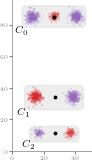

In [13]:
c_faircentroid2, centroids_faircentroid2 = faircentroid.run(n_clusters=3, X=X, s=s, init_centroids=init_centroids2, sensitive_groups=sensitive_groups, lambda_=.9, tol=1e-11)
plot(X=X, s=s, c=c_faircentroid2, centroids=centroids_faircentroid2, figname='toy-3-faircentroids')

In [14]:
kwargs = {'X': X, 's': s, 'display': False}
scores_faircentroid = pd.concat(
    {'initialisation 1': metrics.evaluate(c=c_faircentroid1, centroids=centroids_faircentroid1, **kwargs),
     'initialisation 2': metrics.evaluate(c=c_faircentroid2, centroids=centroids_faircentroid2, **kwargs)
     },
    names=['objectives']
    )
print(tabulate(scores_faircentroid.unstack(level='objectives'), headers='keys', tablefmt='rounded_outline'))

Evaluating against all metrics
Evaluating against all metrics
╭───────────────────────────┬────────────────────┬────────────────────╮
│ metric                    │   initialisation 1 │   initialisation 2 │
├───────────────────────────┼────────────────────┼────────────────────┤
│ average cluster disparity │           0.448718 │           0.448709 │
│ k-means objective         │         154.362    │         155.051    │
│ fair centroid objective   │         159.121    │         152.365    │
│ fair k-means objective    │         175.651    │         176.474    │
╰───────────────────────────┴────────────────────┴────────────────────╯
